# Cooperative Kernel regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## **Partie 1 :** 

Solvers pour les différentes méthodes (on a choisi de faire de la POO)

In [126]:
def kernel(x,y):
    return np.exp(-(x-y)**2)


class instance:
    def __init__(self,X,centers_kernel,Y,kernel_center_of_agent,data_point_of_agent,communication_matrix,sigma) -> None:
        self.centers_kernel=centers_kernel
        self.X = X
        self.Y=Y
        self.kernel_center_of_agent = kernel_center_of_agent
        self.data_point_of_agent = data_point_of_agent
        self.communication_matrix = communication_matrix
        self.sigma = sigma
        number_of_kernels = np.shape(centers_kernel)[0]
        number_of_datas = np.shape(X)[0]
        self.number_of_datas = number_of_datas
        self.number_of_kernels = number_of_kernels
        self.Kmm_matrix = np.array([[kernel(centers_kernel[k],centers_kernel[l]) for k in range(number_of_kernels)]for l in range(number_of_kernels)])
        self.Knm_matrix = np.array([[kernel(centers_kernel[k],X[l]) for k in range(number_of_kernels)]for l in range(self.number_of_datas)])
        number_of_agents,kernels_per_agent = np.shape(kernel_center_of_agent)
        _,data_per_agent = np.shape(data_point_of_agent)
        self.number_of_agents = number_of_agents
        self.kernels_per_agent = kernels_per_agent
        self.data_per_agent = data_per_agent
        matrixA = np.identity(number_of_agents*number_of_kernels)
        for index in range(number_of_kernels):
                matrixA[(number_of_agents-1)*number_of_kernels+index,(number_of_agents-1)*number_of_kernels+index]=0
        for index in range((number_of_agents-1)*number_of_kernels):
                matrixA[index,index+number_of_kernels]=-1
        self.matrixA = matrixA
        self.true_solution = np.zeros(number_of_agents)

    def objective(self,curent_solution):
        objecti = np.dot(curent_solution,np.dot(self.Kmm_matrix,curent_solution))/2
        for agent_index in range(self.number_of_agents):
            for agent_index_2 in range(self.data_per_agent):
                matrix_Kim = np.array([kernel(self.X[self.data_point_of_agent[agent_index,agent_index_2]],self.centers_kernel[j]) for j in range(self.number_of_kernels)])
                objecti+=(1/(2*(self.sigma**2)))*(self.Y[self.data_point_of_agent[agent_index,agent_index_2]]-np.dot(matrix_Kim,curent_solution))**2
        return(objecti)
    
    def gradient(self,agent_index,point):
        sum  = np.dot(self.Kmm_matrix,point)/5    
        for agent_index_2 in range(self.data_per_agent):
            matrix_Kim = np.array([kernel(self.X[self.data_point_of_agent[agent_index,agent_index_2]],self.centers_kernel[j]) for j in range(self.number_of_kernels)])
            sum -=matrix_Kim*(self.Y[self.data_point_of_agent[agent_index,agent_index_2]]-np.dot(matrix_Kim,point))/(self.sigma**2)
        return sum
    
    def complete_gradient(self,point):
        product = np.dot(self.Knm_matrix.T,self.Knm_matrix) 
        grad = np.dot(self.Kmm_matrix+(1/self.sigma**2)*product,point)
        grad -= (1/self.sigma**2)*np.dot(self.Y.T,self.Knm_matrix)
        return(grad)



class solver : 

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        self.instance = instance1
        self.step_size = step_size
        self.number_iteration = number_iteration
        self.initialisation = initialisation
        self.variable_zize = np.shape(initialisation)[0]

class gradient_descent(solver):
    def __init__(self, instance1, step_size, number_iteration, initialisation) -> None:
        super().__init__(instance1, step_size, number_iteration, initialisation)
        self.curent_solution = initialisation
        self.new_solution = initialisation

    def solve(self,verbose = True):
        for iteration in range(self.number_iteration):
            self.do_gradient_descent_step()
            self.curent_solution = self.new_solution
            if verbose:
                self.display_objective()
        return(self.curent_solution)

    def do_gradient_descent_step(self):    
        gradient = self.instance.complete_gradient(self.curent_solution)
        self.new_solution = self.curent_solution - self.step_size*gradient
    
    def display_objective(self):
        print("Objective : "+str(self.instance.objective(self.curent_solution)))


class DGD(solver):
    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))


    def solve(self,verbose = True):
        for iteration in range(self.number_iteration):
            if verbose:
                print("Iterration : "+str(iteration))
            self.do_optimisation_step_DGD(verbose)
            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)
    
    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)
    
    def do_optimisation_step_DGD(self,verbose = True):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index,verbose)
        if verbose : 
            self.display_objective()
        self.curent_solution = self.new_solution

    def do_local_gradient_descent(self,agent_index,verbose=True):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        if verbose : 
            print("Agent " + str(agent_index)+" norme du gradient : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.instance.communication_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))


class gradient_tracking(DGD):

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])
        self.new_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])

    def solve(self,verbose = True):
        for iteration in range(self.number_iteration):
            if verbose :
                print("Iterration : "+str(iteration))
            self.do_optimisation_step_gradient_tracking(verbose)
            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)

    def do_optimisation_step_gradient_tracking(self,verbose=True):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        self.new_gradient_like = np.zeros([self.instance.number_of_agents,self.variable_zize])

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index,verbose)

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_like_update(agent_index)

        self.curent_solution = self.new_solution
        self.curent_gradient_like = self.new_gradient_like
        if verbose :
            self.display_objective()

    def do_local_gradient_descent(self,agent_index,verbose=True):
        gradient = self.curent_gradient_like[agent_index]
        if verbose : 
            print("Agent " + str(agent_index)+" norme du gradient (gradient like) : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.instance.communication_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def do_local_gradient_like_update(self,agent_index):
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_gradient_like[agent_index]+= self.instance.communication_matrix[agent_index,agent_index_2]*self.curent_gradient_like[agent_index_2]
        gradient_iteration_k = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        gradient_iteration_k_plus_1 = self.instance.gradient(agent_index,self.new_solution[agent_index])
        self.new_gradient_like[agent_index]-= gradient_iteration_k
        self.new_gradient_like[agent_index]+= gradient_iteration_k_plus_1
        
    def display_objective(self):
        return super().display_objective()
    
    def update_distance_to_optimum(self, iteration):
        return super().update_distance_to_optimum(iteration)


class dual_decomposition(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = initialisation_dual
        self.new_dual_variable = initialisation_dual
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))


    def solve(self,verbose=True):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            self.compute_primal_variableS()
            self.do_dual_ascent_step(verbose)
            self.curent_dual_variable = self.new_dual_variable
            if verbose :
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
         gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
         agent_index_th_column_of_A = self.instance.matrixA[:,agent_index*self.instance.number_of_kernels:(agent_index+1)*self.instance.number_of_kernels].T
         communication_vector = np.array([self.instance.communication_matrix[agent_index] for index in range(self.instance.number_of_kernels)]).T.flatten()
         components_of_dual_variable_communicated = self.curent_dual_variable*communication_vector
         gradient += np.dot(agent_index_th_column_of_A,components_of_dual_variable_communicated)
         self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
         self.new_primal_solution[agent_index]-=self.step_size*gradient
         

    def do_dual_ascent_step(self,verbose=True):
        self.new_dual_variable = self.curent_dual_variable
        gradient = np.dot(self.instance.matrixA,self.curent_primal_solution.flatten())
        if verbose : 
            print("Norme du gradient : "+str(np.linalg.norm(gradient)))
        self.new_dual_variable += self.step_size_dual*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)

class dual_decomposition_edge(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.new_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))

    def solve(self,verbose=True):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            self.compute_primal_variableS()
            self.do_dual_ascent_step()
            self.curent_dual_variable = self.new_dual_variable
            if verbose : 
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.instance.communication_matrix[agent_index,agent_index_2]*(self.curent_dual_variable[agent_index,agent_index_2]-self.curent_dual_variable[agent_index_2,agent_index])
        self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
        self.new_primal_solution[agent_index]-=self.step_size*gradient
    
    def do_dual_ascent_step(self):
        self.new_dual_variable = self.curent_dual_variable
        for agent_index_1 in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                self.do_dual_ascent_step_on_edge(agent_index_1,agent_index_2)
    
    def do_dual_ascent_step_on_edge(self,agent_index_1,agent_index_2):
        self.new_dual_variable[agent_index_1,agent_index_2]+=self.step_size_dual*(self.curent_primal_solution[agent_index_1]-self.curent_primal_solution[agent_index_2])


    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)


class ADMM(solver):

    def __init__(self,instance1,step_size,number_iteration,initialisation,initialisation_y,beta) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.new_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.curent_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.new_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.beta = beta
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))

    def solve(self,verbose=True):
        for iteration in range(self.number_iteration):
            if verbose : 
                print("Iteration : "+str(iteration))
            self.compute_primal_variableS()
            self.curent_solution = self.new_solution
            self.update_y()
            self.curent_y = self.new_y
            if verbose :
                self.display_objective()
            self.update_distance_to_optimum(iteration)

    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
            self.compute_primal_variable(agent_index)
    
    def compute_primal_variable(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.beta*self.instance.communication_matrix[agent_index,agent_index_2]*(self.curent_solution[agent_index]-self.curent_y[agent_index,agent_index_2])
        self.new_solution[agent_index]=self.curent_solution[agent_index]-self.step_size*gradient

    def update_y(self):
        for agent_index in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                self.do_local_update_y(agent_index,agent_index_2)
    
    def do_local_update_y(self,agent_index,agent_index_2):
        self.new_y[agent_index,agent_index_2]=(self.curent_solution[agent_index]+self.curent_solution[agent_index_2])/2

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)


Import des données

In [54]:
with open("first_database.pkl", "rb") as f:
    x,y = pickle.load(f)
n= 100
m = 10
#mélange et séléction des données
X = x[:n]
Y = y[:n]
stack = np.stack([X,Y]).T
np.random.shuffle(stack)
x_shuffle = stack.T[0]
y_shuffle = stack.T[1]
centers_kernel = np.array([x_shuffle[10*i] for i in range(10)])
kernel_center_of_agent = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])
data_point_of_agent = np.array([np.arange(20*i,20*i+20) for i in range(5)])

Des matrices stochastiques et des matrices d'adjacence pour les différents solvers

In [76]:
#matrices stochastiques (pour DGD et gradient_tracking)
S1 = np.ones((5,5))/5 #fully connected
S2 = (1/5)*np.array([[2,0,1,1,1],[0,3,1,0,1],[1,1,1,1,1],[1,0,1,3,0],[1,1,1,0,2]]) #small world
S3 = (1/3)*np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[1,0,0,1,1]]) #cycle
S4 = (1/3)*np.array([[2,1,0,0,0],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[0,0,0,1,2]]) #line
S5 = (1/4)*np.array([[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[0,0,0,0,4]]) #non connexe

#matrices d'adjacence pour dual decomposition et ADMM
A1 = np.ones((5,5)) #fully connected
A2 = np.array([[1,0,1,1,1],[0,1,1,0,1],[1,1,1,1,1],[1,0,1,1,0],[1,1,1,0,1]]) #small world
A3 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[1,0,0,1,1]]) #cycle
A4 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[0,0,0,1,1]]) #line
A5= np.array([[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[0,0,0,0,1]]) #non connexe

creation de l'instance du problème

In [148]:
instance_pb = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,S1,0.5)

### Mise en oeuvre des différentes méthodes

**Descente de gradient non coopérative** : on prendra la solution $\alpha^{*}$ de la descente non coopérative comme "vraie" valeur de la solution, pour faire les tracés des $\vert\vert \alpha_t-\alpha^{*} \vert\vert$

In [149]:
solver_non_cooperative = gradient_descent(instance_pb,0.0001,2000,np.ones(10))
true_solution = solver_non_cooperative.solve(verbose=False)
instance_pb.true_solution =  true_solution
print(solver_non_cooperative.curent_solution)

[ 0.20802636  0.05346936  0.63045129  0.25122495  0.19971189  0.75256151
 -0.74699421 -0.22392296 -0.98519009  1.09609061]


**Decentralized gradient descent**

In [150]:
solver_DGD = DGD(instance_pb,0.001,1000,np.ones(10))
solver_DGD.solve(verbose=False)
print(solver_DGD.curent_solution)

[[ 0.20852174  0.05401489  0.63312579  0.25469855  0.20330103  0.75502352
  -0.74177946 -0.21941797 -0.98190342  1.09730737]
 [ 0.20396853  0.04932742  0.62280733  0.24417278  0.19278328  0.74490597
  -0.75093389 -0.22961601 -0.98849785  1.0933704 ]
 [ 0.20857521  0.05435674  0.63411988  0.25625746  0.20493316  0.75582438
  -0.73897477 -0.21721422 -0.97932551  1.09579824]
 [ 0.20590734  0.05144172  0.62911716  0.25089598  0.19953541  0.75098571
  -0.74465003 -0.22282828 -0.98423832  1.09450886]
 [ 0.20771192  0.05325139  0.62486909  0.2469205   0.19562     0.74672934
  -0.74652353 -0.22606838 -0.9834889   1.09602373]]


**Gradient tracking**

In [151]:
solver_gradient_tracking = gradient_tracking(instance_pb,0.001,1000,np.ones(10))
solver_gradient_tracking.solve(verbose=False)
print(solver_gradient_tracking.curent_solution)

[[ 0.20804605  0.0534736   0.63051583  0.25124786  0.19972903  0.75263889
  -0.74708258 -0.22395343 -0.98529901  1.09619343]
 [ 0.20804671  0.05347425  0.63051571  0.25124785  0.19972905  0.75263873
  -0.74708223 -0.22395327 -0.98529842  1.09619407]
 [ 0.20804821  0.05347572  0.63051561  0.25124779  0.19972899  0.75263863
  -0.74708198 -0.22395323 -0.98529755  1.0961957 ]
 [ 0.20804706  0.05347462  0.63051631  0.25124848  0.19972967  0.75263932
  -0.74708164 -0.22395265 -0.98529793  1.09619435]
 [ 0.20804731  0.05347487  0.63051637  0.25124856  0.19972976  0.75263937
  -0.74708149 -0.22395253 -0.98529773  1.09619459]]


**Dual decomposition : cloud fashion** Nous avons choisi de tester les deux versions de la dual decompotition : celle ou les multiplicateurs de lagrange sont mis a jour globalment (la version "cloud"), et celle ou ils "vivent" sur les arrêtes du graphe de communication (la version "edge")
Ici, il faut faire attention à un léger détail. L'instance doit être redéfinie et on doit passer en paramètre une matrice d'adjacence (et non plus une matrice stochastique)

In [138]:
instance_pb = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,A1,0.5)
#on doit aussi refixer la "vraie solution"
instance_pb.true_solution =  true_solution

In [139]:
solver_dual_decomposition = dual_decomposition(instance_pb,0.0001,0.0001,10,300,np.ones(10),np.ones(50))
solver_dual_decomposition.solve(verbose=False)
print(solver_dual_decomposition.curent_primal_solution)

[[ 0.18774028  0.06207742  0.5757551   0.24131764  0.19613371  0.68389762
  -0.61899664 -0.17263311 -0.80458881  0.89843284]
 [ 0.18470725  0.08423002  0.43391838  0.1337465   0.09473098  0.53670444
  -0.55952965 -0.21298249 -0.64419167  0.74612067]
 [ 0.06953834  0.02191217  0.41578211  0.17086888  0.14037635  0.50419499
  -0.32370656 -0.0896597  -0.36013808  0.32511649]
 [ 0.15750523  0.05171667  0.46366172  0.18353496  0.14618009  0.5566338
  -0.5219266  -0.1567336  -0.67366145  0.75905711]
 [ 0.18346774  0.10755623  0.33077134  0.07884558  0.04791807  0.42408557
  -0.42109778 -0.1841357  -0.4407428   0.62101311]]


**Dual decomposition : edge fashion**

In [140]:
solver_dual_decomposition_edge = dual_decomposition_edge(instance_pb,0.001,0.001,1,4000,np.ones(10),np.ones(10))
solver_dual_decomposition_edge.solve(verbose = False)
print(solver_dual_decomposition_edge.curent_primal_solution)

[[ 0.08325971 -0.12709888  0.55534641  0.32616044  0.29058227  0.61642016
  -0.58872433 -0.04394625 -1.18359643  1.4480525 ]
 [ 0.0974891  -0.11080728  0.52015863  0.27255697  0.23494516  0.58846373
  -0.65545819 -0.11164352 -1.19911067  1.43231862]
 [ 0.11301549 -0.08959946  0.57978869  0.31854043  0.27942864  0.65348715
  -0.62270402 -0.07631048 -1.15529782  1.40817954]
 [ 0.08882119 -0.11939642  0.5499819   0.30635131  0.26911452  0.61654008
  -0.62387591 -0.07603409 -1.19077293  1.42882466]
 [ 0.1172012  -0.09212993  0.52538405  0.27827115  0.24086282  0.59406267
  -0.64297164 -0.10327323 -1.18377867  1.46029026]]


**ADMM** 

In [141]:
solver_ADMM = ADMM(instance_pb,0.001,1000,np.ones(10),np.ones(10),50)
solver_ADMM.solve(verbose= False)
print(solver_ADMM.curent_solution)

[[ 0.20683834  0.05289504  0.64521764  0.26577873  0.21430699  0.76767538
  -0.73116635 -0.20867278 -0.97530469  1.09412837]
 [ 0.19994165  0.04614238  0.60263765  0.2256315   0.17464303  0.7248786
  -0.7566384  -0.24327893 -0.98607657  1.0855898 ]
 [ 0.20315186  0.05114731  0.64271788  0.26697383  0.21601577  0.76403814
  -0.71996066 -0.2026922  -0.963077    1.07973311]
 [ 0.19939285  0.04613381  0.62642446  0.25024032  0.19924053  0.74797192
  -0.73701479 -0.21971826 -0.97743687  1.08309134]
 [ 0.21320329  0.06043706  0.60334516  0.2299113   0.17942227  0.72447925
  -0.74187659 -0.23425696 -0.96614093  1.0926295 ]]


### **Tracés**

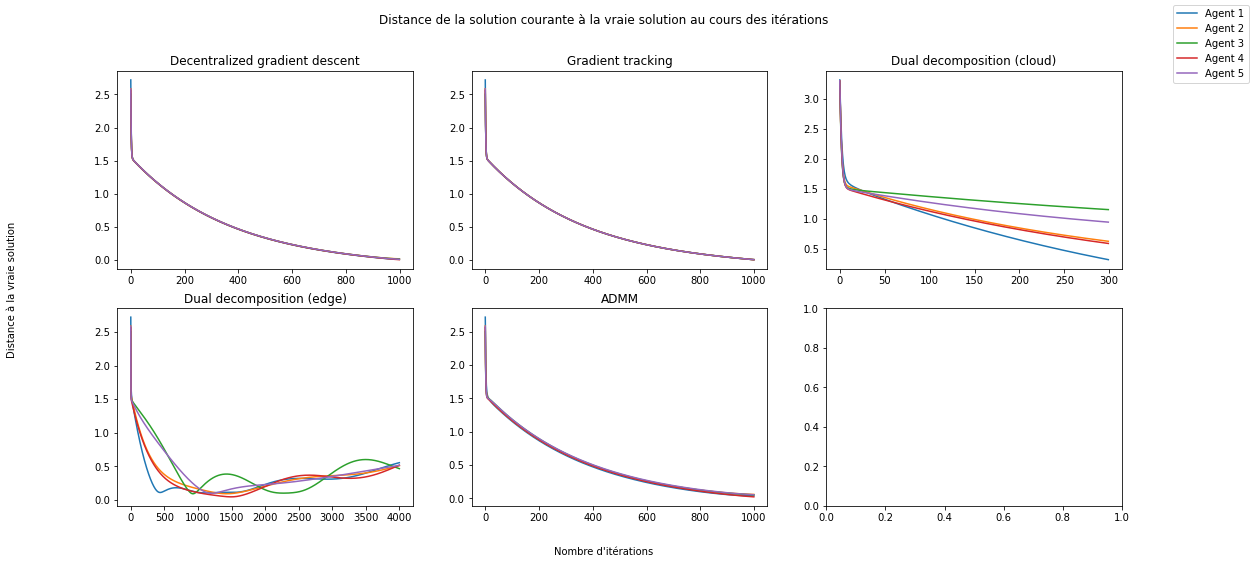

In [152]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

axs[0,0].plot(solver_DGD.distance_to_optimum)
axs[0,0].set_title("Decentralized gradient descent")
axs[0,1].plot(solver_gradient_tracking.distance_to_optimum)
axs[0,1].set_title("Gradient tracking")
axs[0,2].plot(solver_dual_decomposition.distance_to_optimum)
axs[0,2].set_title("Dual decomposition (cloud)")
axs[1,0].plot(solver_dual_decomposition_edge.distance_to_optimum)
axs[1,0].set_title("Dual decomposition (edge)")
axs[1,1].plot(solver_ADMM.distance_to_optimum)
axs[1,1].set_title("ADMM")
fig.text(0.5, 0.04, "Nombre d'itérations", ha='center')
fig.text(0.04, 0.5, "Distance à la vraie solution", va='center', rotation='vertical')

fig.suptitle("Distance de la solution courante à la vraie solution au cours des itérations")
fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()


### Visualisation de la fonction obtenue

In [143]:
def f(alpha,centers_kernel,x):
    number_of_kernels = np.shape(centers_kernel)[0]
    kernels = np.array([kernel(x,centers_kernel[i]) for i in range(number_of_kernels)])
    return(np.dot(alpha,kernels))

In [144]:
t = np.linspace(-1,1,250)

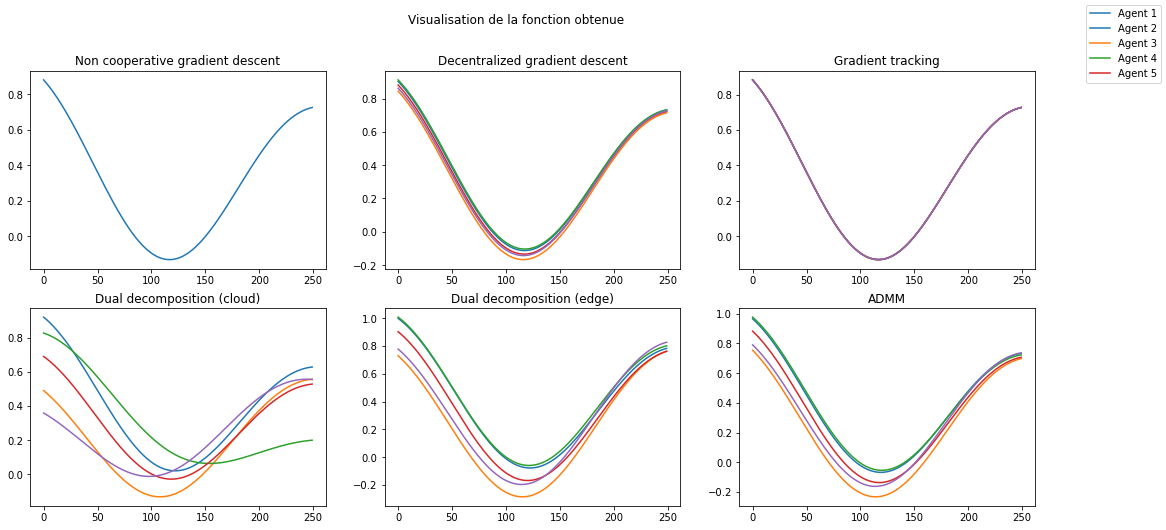

In [153]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

estimee_gradient_descent = np.array([f(solver_non_cooperative.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[0,0].plot(estimee_gradient_descent)
axs[0,0].set_title("Non cooperative gradient descent")
estimee_DGD = np.array([f(solver_DGD.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[0,1].plot(estimee_DGD)
axs[0,1].set_title("Decentralized gradient descent")
estimee_gradient_tracking = np.array([f(solver_gradient_tracking.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[0,2].plot(estimee_gradient_tracking)
axs[0,2].set_title("Gradient tracking")
estimee_dual= np.array([f(solver_dual_decomposition.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
axs[1,0].plot(estimee_dual)
axs[1,0].set_title("Dual decomposition (cloud)")
estimee_dual_cloud = np.array([f(solver_dual_decomposition_edge.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
axs[1,1].plot(estimee_dual_cloud)
axs[1,1].set_title("Dual decomposition (edge)")
estimee_ADMM = np.array([f(solver_ADMM.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[1,2].plot(estimee_ADMM)
axs[1,2].set_title("ADMM")
fig.suptitle("Visualisation de la fonction obtenue")
fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()

### Tracés pour d'autre structures de graphe

In [154]:
def train_all_models(stochastic_matrix,adjacence_matrix):
    instance_pb_with_stochastic_matrix = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,stochastic_matrix,0.5)
    instance_pb_with_adjacence_matrix = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,adjacence_matrix,0.5)
    #computing the "true_solution"
    solver_non_cooperative = gradient_descent(instance_pb_with_stochastic_matrix,0.0001,2000,np.ones(10))
    true_solution = solver_non_cooperative.solve(verbose=False)
    instance_pb_with_stochastic_matrix.true_solution =  true_solution
    instance_pb_with_adjacence_matrix.true_solution =  true_solution
    #DGD & gradient tracking
    solver_DGD = DGD(instance_pb_with_stochastic_matrix,0.001,1000,np.ones(10))
    solver_DGD.solve(verbose=False)
    solver_gradient_tracking = gradient_tracking(instance_pb_with_stochastic_matrix,0.001,1000,np.ones(10))
    solver_gradient_tracking.solve(verbose=False)
    #Dual decompo (edge & cloud) & ADMM
    solver_dual_decomposition = dual_decomposition(instance_pb_with_adjacence_matrix,0.0001,0.0001,10,300,np.ones(10),np.ones(50))
    solver_dual_decomposition.solve(verbose=False)
    solver_dual_decomposition_edge = dual_decomposition_edge(instance_pb_with_adjacence_matrix,0.001,0.001,1,4000,np.ones(10),np.ones(10))
    solver_dual_decomposition_edge.solve(verbose=False)
    solver_ADMM = ADMM(instance_pb_with_adjacence_matrix,0.001,1000,np.ones(10),np.ones(10),50)
    solver_ADMM.solve(verbose=False)
    #ploting convergence
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

    axs[0,0].plot(solver_DGD.distance_to_optimum)
    axs[0,0].set_title("Decentralized gradient descent")
    axs[0,1].plot(solver_gradient_tracking.distance_to_optimum)
    axs[0,1].set_title("Gradient tracking")
    axs[0,2].plot(solver_dual_decomposition.distance_to_optimum)
    axs[0,2].set_title("Dual decomposition (cloud)")
    axs[1,0].plot(solver_dual_decomposition_edge.distance_to_optimum)
    axs[1,0].set_title("Dual decomposition (edge)")
    axs[1,1].plot(solver_ADMM.distance_to_optimum)
    axs[1,1].set_title("ADMM")
    fig.text(0.5, 0.04, "Nombre d'itérations", ha='center')
    fig.text(0.04, 0.5, "Distance à la vraie solution", va='center', rotation='vertical')

    fig.suptitle("Distance de la solution courante à la vraie solution au cours des itérations")
    fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
    plt.show()
    
    #ploting the obtained function
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

    estimee_gradient_descent = np.array([f(solver_non_cooperative.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,0].plot(estimee_gradient_descent)
    axs[0,0].set_title("Non cooperative gradient descent")
    estimee_DGD = np.array([f(solver_DGD.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,1].plot(estimee_DGD)
    axs[0,1].set_title("Decentralized gradient descent")
    estimee_gradient_tracking = np.array([f(solver_gradient_tracking.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,2].plot(estimee_gradient_tracking)
    axs[0,2].set_title("Gradient tracking")
    estimee_dual= np.array([f(solver_dual_decomposition.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,0].plot(estimee_dual)
    axs[1,0].set_title("Dual decomposition (cloud)")
    estimee_dual_cloud = np.array([f(solver_dual_decomposition_edge.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,1].plot(estimee_dual_cloud)
    axs[1,1].set_title("Dual decomposition (edge)")
    estimee_ADMM = np.array([f(solver_ADMM.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,2].plot(estimee_ADMM)
    axs[1,2].set_title("ADMM")
    fig.suptitle("Visualisation de la fonction obtenue")
    fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
    plt.show()

    

**Fully connected**

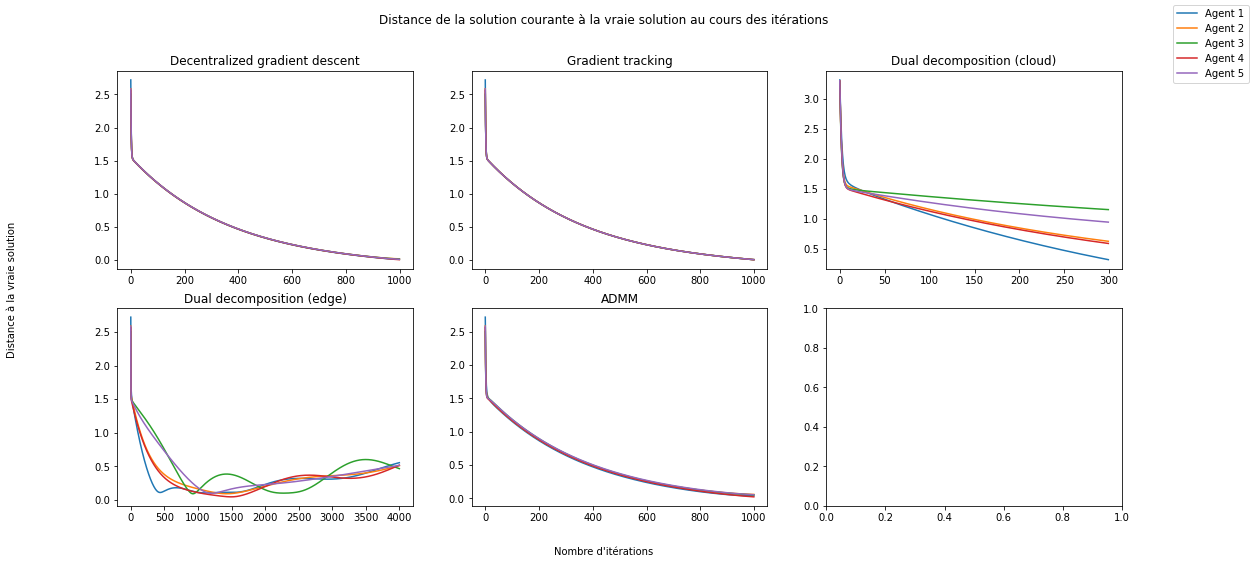

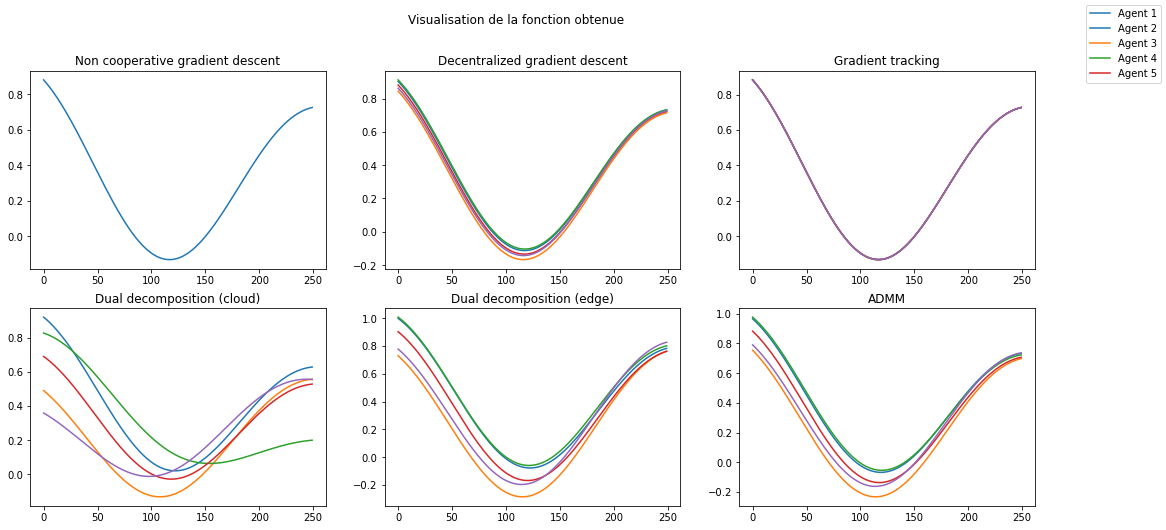

In [155]:
train_all_models(S1,A1)

**Small world**

In [156]:
train_all_models(S2,A2)

**Cycle**

In [ ]:
train_all_models(S3,A3)

**Line**

In [ ]:
train_all_models(S4,A4)

**Non connex**

In [ ]:
train_all_models(S5,A5)